# Regresión Logística

Mateo Rosero

## Explicaciones Clave
**Sobre el dataset:** ``loan_data.csv`` contiene datos para determinar si un préstamo será aprobado o no (loan_status) según ciertas variables independientes:
- person_age --> Edad de la persona
- person_income --> Ingreso anual de la persona
- person_emp_exp --> Años de experiencia laboral
- loan_amnt --> Cantidad de dinero solicitado para el préstamo
- loan_int_rate --> Tasa de Interés del préstamo
- loan_percent_income --> Porcentaje de la cantidad de dinero solicitado en el préstamo en relación al Ingreso anual de la persona.
- cb_person_cred_hist_length --> Longitud del historial crediticio en años.
- credit_score --> Score crediticio de la persona

**Entrenamiento del modelo:** Se utilizará la librería de ``skearn`` para poder implementar algoritmos de Regresión Logística.<br>

# Importar Librerías Necesarias

In [173]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, log_loss
import seaborn as sns
import statsmodels.api as sm

# Importar el Dataset

In [174]:
dataset = pd.read_csv('loan_data.csv')

# Definición de Variable Independiente y Dependiente

In [175]:
X = dataset[['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 
             'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score']].values
y = dataset['loan_status'].values

En este dataset, la aprobación del préstamo está dada por algunas variables como la edad de la persona, su ingreso, su experiencia labora, score crediticio, entre otras. Por esta razón, esta variable cualitativa dicotómica es la variable dependiente y las demás variables numéricas son variables independientes.

# División entre Conjunto de Entrenamiento y Conjunto de Prueba

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Escalado de Características (Feature Scaling)

In [177]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Entrenando el Modelo de Regresión Logística sobre el Conjunto de Entrenamiento

In [178]:
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

LogisticRegression(random_state=0)

# Predicciones

## Sobre un nuevo resultado

**Ejemplo:** Persona de 35 años, ingreso 50000, 5 años de experiencia, solicita un préstamo con tasa de interés del 12%, el préstamo representa 20% del ingreso, tiene un score crediticio de 650.

In [179]:
nueva_muestra = [[35, 50000, 5, 10000, 12.0, 0.20, 4, 650]]
nueva_muestra_escalada = sc.transform(nueva_muestra)

prediccion = classifier.predict(nueva_muestra_escalada)
probabilidades = classifier.predict_proba(nueva_muestra_escalada)

print(f"Predicción del préstamo: {'Aprobado' if prediccion[0] == 1 else 'Rechazado'}")
print(f"Probabilidad de rechazo: {probabilidades[0][0]:.2f}")
print(f"Probabilidad de aprobación: {probabilidades[0][1]:.2f}")

Predicción del préstamo: Rechazado
Probabilidad de rechazo: 0.59
Probabilidad de aprobación: 0.41


## Sobre el Conjunto de Prueba

In [180]:
y_pred = classifier.predict(X_test)
y_prob = classifier.predict_proba(X_test)[:, 1]
print("Predicciones sobre el conjunto de prueba:")
print(np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test), 1)), 1)) 

Predicciones sobre el conjunto de prueba:
[[0 1]
 [0 0]
 [0 0]
 ...
 [0 0]
 [0 1]
 [0 0]]


# ANÁLISIS

# Matriz de Confusión

La matriz de confusión nos permite visualizar los verdaderos positivos, falsos positivos, verdaderos negativos y falsos negativos. Se evalúa comparando las predicciones con los valores reales.
- Un buen modelo tendrá valores altos en la diagonal principal.

In [159]:
print("Matriz de Confusión:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

Matriz de Confusión:
[[8268  495]
 [1473 1014]]


La matriz de confusión dio los siguientes resultados:
- 8268 verdaderos negativos (préstamos correctamente predichos como rechazados).
- 1014 verdaderos positivos (préstamos correctamente predichos como aprobados).
- 495 falsos positivos (préstamos que fueron aprobados incorrectamente cuando deberían haber sido rechazados).
- 1473 falsos negativos (préstamos rechazados incorrectamente cuando deberían haber sido aprobados).<br>
Esto nos indica que, a pesar de haber una gran cantidad de predicciones correctas, _**el modelo comete muchos falsos negativos**_, lo cual puede ser un problema en un escenario de la vida real cuando no se quiera rechazar a buenos solicitantes.

# Accuracy

Mide el porcentaje de predicciones correctas del modelo sobre el total de los casos.

In [160]:
print("Precisión global (Accuracy):")
print(accuracy_score(y_test, y_pred))

Precisión global (Accuracy):
0.8250666666666666


El modelo _**acierta en un 82.5% de los casos**_, lo cual _**está bien a nivel general**_.

# Precision

Otorga un resultado en el que indica, de todas las veces que el modelo dio un resultado positivo, ¿Cuántas veces acertó?<br>
Su interpretación se realiza de la siguiente manera:
- **Precision alta (> 0.7):** El modelo tiene un _**bajo número de falsos positivos**_. Es decir, cuando predice que algo es positivo, generalmente tiene razón.
- **Precision baja (< 0.5):** El modelo está haciendo _**muchos falsos positivos**_. En estos casos, el modelo tiende a etiquetar incorrectamente como positivos muchos ejemplos negativos, lo que puede ser un problema si la consecuencia de un falso positivo es costosa, como los casos de arrestar a una persona inocente o diagnosticar erróneamente una enfermedad.

In [161]:
print("Precisión (Precision):")
print(precision_score(y_test, y_pred))

Precisión (Precision):
0.6719681908548708


En esta métrica, el valor obtenido nos indica que, de todos los préstamos que el modelo dijo que serían aprobados, _**el 67% en verdad lo fueron**_. Esto indica que _**el modelo es relativamente confiable cuando aprueba los préstamos, aunque no es perfecto**_.

# Curva ROC y Área bajo la Curva ROC (AUC)

Por un lado, la Curva ROC (_Receiver Operating Characteristic_), es una gráfica que muestra cómo cambia el modelo si se ajusta el umbral de clasificación, teniendo al eje X como la Tasa de Falsos Positivos (FPR) y al eje Y como la Tasa de Verdaderos Positivos (TPR). Una curva más cerca de la esquina superior izquierda indica que es un mejor modelo.<br>
Generalmente, si hay una _**curva cerca de la esquina superior izquierda**_, el modelo tiene una alta capacidad de discriminación, lo que significa que es muy bueno para separar las clases (Cuanto más hacia la esquina superior izquierda, mejor), y cuando hay una **_curva cerca de la diagonal (línea punteada)_**, esto indica un modelo que tiene un rendimiento similar al azar (AUC cercano a 0.5), por lo que no está discriminando bien las clases.

Por otro lado, la Área bajo la curva ROC (_AUC_) resume la ROC con un número entre 0 y 1. Mientras más cercano a 1, mejor el modelo distingue entre las clases. <br>
Se interpreta de la siguiente forma:
- **AUC alto (> 0.8):** El modelo tiene una excelente capacidad para separar las clases. Cuanto más cerca de 1, mejor.
- **AUC cercano a 0.5:** El modelo es prácticamente aleatorio y no tiene capacidad de discriminación.
- **AUC bajo (< 0.6):** El modelo tiene una muy baja capacidad de discriminación y probablemente no sea útil.

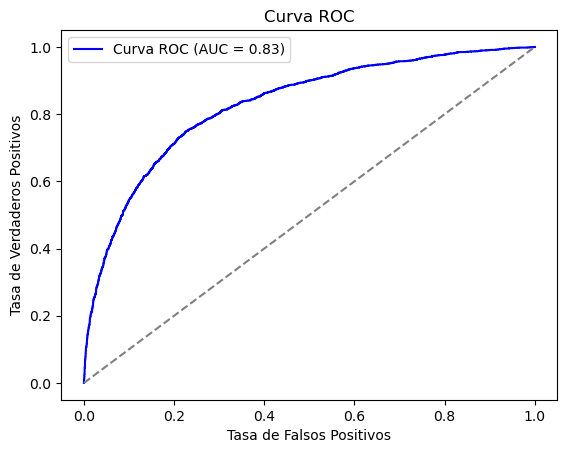

Área bajo la curva (AUC):
0.8283709776745731


In [162]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

print("Área bajo la curva (AUC):")
print(auc_score)

A nivel gráfico, _**la curva sí se acerca a la esquina superior izquierda**_ y, combinando el hecho de que su AUC tiene un valor de **0.83**, se puede decir que _**el modelo tiene buena capacidad de clasificación entre los préstamos aprobados y rechazados**_.

# Coeficientes del Modelo (Odds Ratio)

En regresión logística, cada variable tiene un coeficiente que representa su efecto sobre la probabilidad logarítmica de que ocurra el evento. Estos coeficientes son los Odds Ratio (OR). <br>
Su evaluación se interpreta así:
- **OR > 1:** La variable aumenta la probabilidad del evento positivo.
- **OR < 1:** La variable disminuye la probabilidad del evento positivo.
- **OR alrededor de 1:** No tiene un gran impacto en las probabilidades de que ocurra el evento.

In [163]:
print("Coeficientes del modelo:")
for feature, coef in zip(dataset.columns[0:-1], classifier.coef_[0]):
    print(f"{feature}: {coef}")

Coeficientes del modelo:
person_age: 0.1088855236486517
person_gender: 0.021773424416748965
person_education: -0.08032403667547776
person_income: -0.7013866883152998
person_emp_exp: 1.001027550769092
person_home_ownership: 1.3656133478549577
loan_amnt: -0.017462144412300512
loan_intent: -0.014425441329139945


Dados los coeficientes calculados, se puede concluir con lo siguiente: 
- A mayor edad, aumenta ligeramente la probabilidad de que se apruebe el préstamo.
- El género de la persona tiene un impacto muy bajo en la predicción.
- A mayor nivel educativo, existe una muy ligeramente menor probabilidad de aprobación de un préstamo.
- A mayor ingreso, menor probabilidad de que se rechace el préstamo, lo que puede indicar que el modelo considera que personas con mayores ingresos son más confiables.
- Más experiencia laboral incrementa significativamente la probabilidad de aprobación.
- Tener vivienda propia aumenta significativamente la probabilidad de aprobación.
- Préstamos más grandes se asocian con menor probabilidad de aprobación.